<br/>

$$ \huge{\underline{\textbf{ REINFORCE }}} $$

<br/>

<center>Implementation of <b>REINFORCE</b> algorithm</center>
<center>from Sutton and Barto 2018, <b>chapter 13.3</b>.</center>
<center>Book available for free <a href="http://incompleteideas.net/book/the-book-2nd.html">here</a></center>

<br/>

<img src="assets/1303_REINFORCE.png"/>
<center> From Sutton and Barto (2018) _Reinforcement Learning: An Introduction_, chapter 13.3 </center>

<br/>

<span style="color: red">TODO: rewrite</span>

Differences from the box (see [chapter 9.3](0903a_Gradient_MC.ipynb) for explicit implementation example):
* $\hat{q}$ is a black box trainable function approximator, benefits:
  * avoid explicitly passing around $\mathbf{w}$ - which can be quite complicated structure in some cases (e.g. neural net)
  * avoid computing and stroing $\nabla\hat{q}(S,A,\mathbf{w})$ explicitly - which also can be complicated structure
* don't initialize $\mathbf{w}$ - one we don't know structure of $\mathbf{w}$, two maybe user want's to continue training
* add callback and trace params, so we can track what is going on

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class BanditEnv:
    def __init__(self):
        """10-armed testbed, see chapter 2.3"""
        self._done = False
        self.nb_states = 1
        self.nb_actions = 10              # 10 arms
        # self.means = np.random.normal(scale=1.0, size=self.size)
        self.means = np.array([0.25, -0.75, 1.5, 0.5, 1.25,   # eyeball fig 2.1
                               -1.5, -0.25, -1, 0.75, -0.5])
    
    def reset(self):
        self._done = False
        return 0  # observation
        
    def step(self, action):
        assert not self._done
        self._done = True
        return 0, np.random.normal(loc=self.means[action]), self._done, None

In [3]:
class CorridorSwitchedEnv:
    def __init__(self):
        self.nb_states = 1
        self.nb_actions = 2
        self._state = 0
        
    def reset(self):
        self._state = 0
        return 0        # states are indistinguisable
    
    def step(self, action):
        assert action in [0, 1]  # left, right
        
        if self._state == 0:
            if action == 1:
                self._state = 1
        elif self._state == 1:
            if action == 0:  # left, swapped to right
                self._state = 2
            else:            # right, swapped to left
                self._state = 0
        elif self._state == 2:
            if action == 0:
                self._state = 1
            else:
                self._state = 3  # terminal
        else:
            raise ValueError('Invalid state:', self._state)
        
        observation = 0  # states are indistinguisable
        if self._state == 3:
            return observation, -1, True, None
        else:
            return observation, -1, False, None

In [4]:
def softmax(x):
    """Numerically stable softmax"""
    ex = np.exp(x - np.max(x))
    return ex / np.sum(ex)

In [18]:
class TabularSoftmaxPolicy:
    """Tabular action-state function 'approximator'"""
    def __init__(self, learn_rate, nb_states, nb_actions, init_theta=None):
        self._lr = learn_rate
        self._nb_states = nb_states
        self._nb_actions = nb_actions
        self._theta = np.zeros(nb_states * nb_actions)     # weights
        if init_theta is not None:
            assert init_theta.dtype == np.float64
            assert init_theta.shape == self._theta.shape
            self._theta = init_theta
    
    def x(self, state, action):
        """Feature vecotr, in our case just one-hot encode"""
        xx = np.zeros(self._nb_states * self._nb_actions)  # construct x(s,a)
        xx[state*self._nb_actions + action] = 1            # one-hot encode
        return xx
        
    def h(self, state, action):
        """Calculate preference h(s,a,theta), see e.q. 13.3"""
        return self._theta @ self.x(state, action)      # scalar, e.q. 13.3
    
    def pi(self, state):
        
        # Option 1: as described in the book
        # construct vector x(s,a) for each action
        # perform full linear combination (e.q. 13.3)
#         h_vec = [self.h(state, b)
#                  for b in range(self._nb_actions)]   # shape=[n_act]
        
        # Option 2: optimized
        # h(state, action) == self._theta[state * self._nb_actions + action]
        # which leads to simplified expression below
        h_vec_2 = self._theta[state*self._nb_actions:state*self._nb_actions+self._nb_actions]
#         assert np.alltrue(h_vec == h_vec_2)
        
        prob_vec = softmax(h_vec_2)                     # shape=[n_act], e.q. 13.2
        
        return prob_vec


    def update(self, state, action, disc_return):
        # Option 1: as described in the book
#         prob_vec = self.pi(state)                   # shape=[n_act]
#         sum_b = [prob_vec[b]*self.x(state,b)        # shape=[n_s*n_a]
#                  for b in range(self._nb_actions)]
#         sum_b = np.sum(sum_b, axis=0)
#         grad_ln_pi = self.x(state, action) - sum_b  # shape=[n_s*n_a], e.q. 13.9
        
        # Option 2: Optimized
        x_s = np.zeros(self._nb_actions)
        x_s[action] = 1
        prob = self.pi(state)
        grad_s = x_s - prob
        
        grad_ln_pi_2 = np.zeros(self._nb_states * self._nb_actions)
        grad_ln_pi_2[state*self._nb_actions:state*self._nb_actions+self._nb_actions] = grad_s
#         assert np.alltrue(grad_ln_pi == grad_ln_pi_2)
        
        self._theta += self._lr * disc_return * grad_ln_pi_2  # e.q. 13.8

In [6]:
def basic_test(env, ep, alpha):
    
    pi = TabularSoftmaxPolicy(learn_rate=alpha, nb_states=env.nb_states, nb_actions=env.nb_actions)

    hist_R = []
    hist_prob = []
    
    for i in range(ep):
        _ = env.reset()
        
        prob = pi.pi(state=0)
    #     prob = prob + 1e-2
    #     prob = prob / prob.sum()
    #     prob.sum()
        A = np.random.choice(range(env.nb_actions), p=prob)
        
        _, R, _, _ = env.step(A)
        
        _ = np.random.choice(range(env.nb_actions), p=prob)  # dummy
        
        pi.update(state=0, action=A, disc_return=R)

        hist_R.append(R)
        hist_prob.append(prob)

    hist_R = np.array(hist_R)
    hist_prob = np.array(hist_prob)
    
    return hist_R, hist_prob

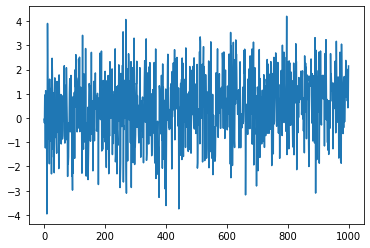

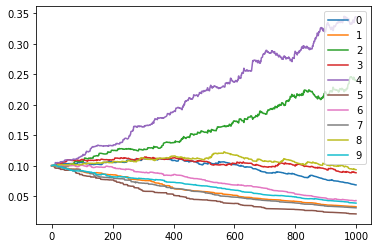

In [12]:
env = BanditEnv()

np.random.seed(4)

hist_R, hist_prob = basic_test(env, ep=1000, alpha=1e-2)

plt.plot(hist_R)
plt.show()
for i in range(env.nb_actions):
    plt.plot(hist_prob[:,i], label=i)
plt.legend()
plt.show()

In [8]:
def generate_episode(env, policy, *params):
    """Generete one complete episode.
    
    Returns:
        trajectory: list of tuples [(st, rew, done, act), (...), (...)],
                    where St can be e.g tuple of ints or anything really
        T: index of terminal state, NOT length of trajectory
    """
    trajectory = []
    done = True
    while True:
        # === time step starts here ===
        if done:  St, Rt, done    = env.reset(), None, False
        else:     St, Rt, done, _ = env.step(At)
        At = policy(St, *params)        
        trajectory.append((St, Rt, done, At))
        if done:  break
        # === time step ends here ===
    return trajectory, len(trajectory)-1

In [16]:
def REINFORCE(env, ep, gamma, alpha, init_theta=None):
    def policy(st, pi):
        prob = pi.pi(st)
#         prob = prob + 0.01
#         prob = prob / prob.sum()
#         prob.sum()
        min_ = np.argmin(prob)
#         if prob[min_] < 0.05:
#             prob = [0.95, 0.95]
#             prob[min_] = 0.05
            
        return np.random.choice(range(env.nb_actions), p=prob)

    hist_prob = []
    hist_G_0 = []
    pi = TabularSoftmaxPolicy(learn_rate=alpha, nb_states=env.nb_states, nb_actions=env.nb_actions, init_theta=init_theta)

    for e_ in range(ep):
        # print(e_)
        traj, T = generate_episode(env, policy, pi)
        
        #for t in range(0, T):
        #    St, _, _, At = traj[t]                           # (st, rew, done, act)
        #    Gt = sum([traj[i][1] for i in range(t+1, T+1)])  # <- this is inefficient
        
        Gt = 0
        for t in range(T-1,-1,-1):
            St, _, _, At = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            Gt = gamma * Gt + Rt_1
        
            pi.update(St, At, Gt)

            prob = pi.pi(St)
            # print(prob)
            
        hist_prob.append(prob)
        hist_G_0.append(Gt)

    hist_prob = np.array(hist_prob)
    hist_G_0 = np.array(hist_G_0)
    
    return hist_G_0, hist_prob

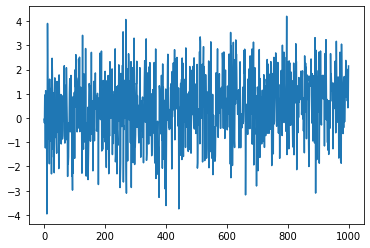

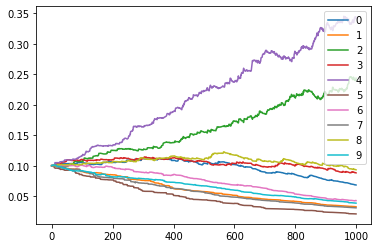

In [11]:
env = BanditEnv()

np.random.seed(4)

hist_R, hist_prob = REINFORCE(env, ep=1000, gamma=1.0, alpha=1e-2)

plt.plot(hist_R)
plt.show()

for i in range(env.nb_actions):
    plt.plot(hist_prob[:,i], label=i)
plt.legend()
plt.show()

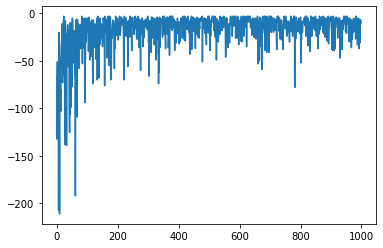

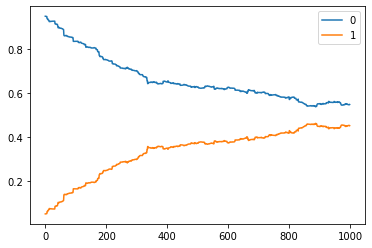

In [21]:
env = CorridorSwitchedEnv()

np.random.seed(1)

hist_R, hist_prob = REINFORCE(env, ep=1000, gamma=1.0, alpha=2**-13, init_theta=np.array([1.47, -1.47]))

plt.plot(hist_R)
plt.show()

for i in range(env.nb_actions):
    plt.plot(hist_prob[:,i], label=i)
plt.legend()
plt.show()

In [31]:
np.random.seed(1)

env = CorridorSwitchedEnv()

runs_a13 = []

for i in range(100):
    hist_R, hist_prob = REINFORCE(env, ep=50, gamma=1.0, alpha=2**-13, init_theta=np.array([1.47, -1.47]))
    runs_a13.append(hist_R)
    
    if (i+1) % 10 == 0: print(i+1)

runs_a13 = np.array(runs_a13)

10
20
30
40
50
60
70
80
90
100


In [32]:
runs_a13_avg = np.average(runs_a13, axis=0)

(0, 1000)

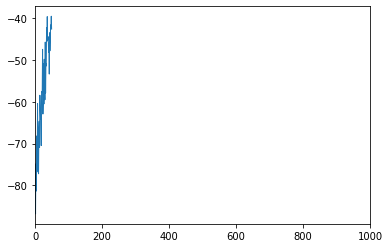

In [35]:
plt.plot(runs_a13_avg, linewidth=1.0)
plt.xlim(0,1000)

In [1]:
def ep_semi_grad_sarsa(env, ep, gamma, eps, q_hat, callback=None, trace=None):
    """Episodic Semi-Gradient Sarsa
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        eps - epsilon-greedy param
        q_hat      - function approximator, already initialised, with methods:
                     eval(state, action) -> float
                     train(state, target) -> None
    """
    def policy(st, q_hat, eps):
        if np.random.rand() > eps:
            q_values = [q_hat.eval(st,a) for a in env.act_space]
            return argmax_rand(q_values)
        else:
            return np.random.choice(env.act_space)
        
    # skip weight intialization, 
    
    for e_ in range(ep):
        S = env.reset()
        A = policy(S, q_hat, eps)
        for t_ in range(10**100):       
            S_, R, done = env.step(A)
            if done:
                q_hat.train(S, A, R)
                break
            A_ = policy(S_, q_hat, eps)
            target = R + gamma * q_hat.eval(S_, A_)
            q_hat.train(S, A, target)
            S, A = S_, A_
                
            if callback is not None:
                callback(e_, t_, q_hat, trace)

Tile Coding - see [chapter 9.5](0905b_LM_Agg_Tile.ipynb) for introduction

In [2]:
class TileCodingFuncApprox():
    def __init__(self, st_low, st_high, nb_actions, learn_rate, num_tilings, init_val):
        """
        Params:
            st_low      - state space low boundry in all dim, e.g. [-1.2, -0.07] for mountain car
            st_high     - state space high boundry in all dimensions
            nb_actions  - number of possible actions
            learn_rate  - step size, will be adjusted for nb_tilings automatically
            num_tilings - tiling layers - should be power of 2 and at least 4*len(st_low)
            init_val    - initial state-action values
        """
        assert len(st_low) == len(st_high)
        self._n_dim = len(st_low)
        self._lr = learn_rate / num_tilings
        self._num_tilings = num_tilings
        self._scales = self._num_tilings / (st_high - st_low)
        
        # e.g. 8 tilings, 2d space, 3 actions
        # nb_total_tiles = (8+1) * (8+1) * 8 * 3
        nb_total_tiles = (num_tilings+1)**self._n_dim * num_tilings * nb_actions
                
        self._iht = tiles3.IHT(nb_total_tiles)
        self._weights = np.zeros(nb_total_tiles) + init_val / num_tilings
        
    def eval(self, state, action):
        assert len(state) == self._n_dim
        assert np.isscalar(action)
        scaled_state = np.multiply(self._scales, state)  # scale state to map to tiles correctly
        active_tiles = tiles3.tiles(                     # find active tiles
            self._iht, self._num_tilings,
            scaled_state, [action])
        return np.sum(self._weights[active_tiles])       # pick correct weights and sum up

    def train(self, state, action, target):
        assert len(state) == self._n_dim
        assert np.isscalar(action)
        assert np.isscalar(target)
        scaled_state = np.multiply(self._scales, state)  # scale state to map to tiles correctly
        active_tiles = tiles3.tiles(                     # find active tiles
            self._iht, self._num_tilings,
            scaled_state, [action])
        value = np.sum(self._weights[active_tiles])      # q-value for state-action pair
        delta = self._lr * (target - value)              # grad is [0,1,0,0,..]
        self._weights[active_tiles] += delta             # ..so we pick active weights instead

Helper functions

In [3]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == np.max(arr)))

<table>
    <tr>
        <td style="border-color: white;"><img src="assets/fig_1001.png"/></td>
    </tr>
    <tr>
        <td style="border-color: white;"><center>Figure 10.1 - "Step 483" replaced with "Episode 1" due to better reproducibility of bucket shape.<center/></td>
    </tr>
</table>

---

# Solve Mountain Car

Imports (source file: [tiles3.py](tiles3.py), [helpers_1001.py](helpers_1001.py))

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import axes3d
from mountain_car import MountainCarEnv
from helpers_1001 import eval_state_action_space, plot_q_max_3d
import tiles3           # by Richard Sutton, http://incompleteideas.net/tiles/tiles3.html

Environment

In [5]:
env = MountainCarEnv()

Create function approximator and solve

In [6]:
q_hat = TileCodingFuncApprox(env.state_low, env.state_high, len(env.act_space),
                             learn_rate=0.3, num_tilings=8, init_val=0)
ep_semi_grad_sarsa(env, ep=500, gamma=1.0, eps=0.0, q_hat=q_hat)

Plot

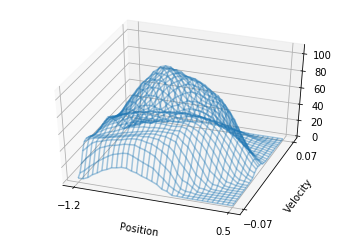

In [7]:
q_arr = eval_state_action_space(q_hat, env)
plot_q_max_3d(q_arr, env, labels=['Position', 'Velocity', ''], alpha=0.4)

# Recreate figure 10.1

We will need callback to capture q-value array for whole state-action space at specified episodes.

In [8]:
def callback(episode, tstep, model, trace):
    """Called from gradient_MC after every episode.
    
    Params:
        episode [int] - episode number
        tstep [int]   - timestep within episode
        model [obj]   - function approximator
        trace [list]  - list to write results to"""
    episodes = [1, 12, 104, 1000, 9000]
    if episode in episodes and tstep == 0:
        q_arr = eval_state_action_space(q_hat, env)
        trace.append(q_arr)

In [9]:
trace = []
q_hat = TileCodingFuncApprox(env.state_low, env.state_high, len(env.act_space),
                             learn_rate=0.3, num_tilings=8, init_val=0)
ep_semi_grad_sarsa(env, ep=20, gamma=1.0, eps=0.0, q_hat=q_hat, callback=callback, trace=trace)

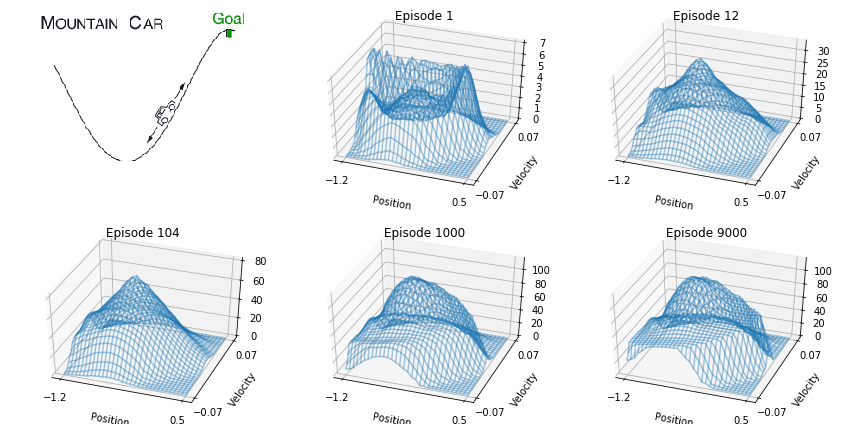

In [289]:
fig = plt.figure(figsize=[12,6])
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232, projection='3d')
ax3 = fig.add_subplot(233, projection='3d')
ax4 = fig.add_subplot(234, projection='3d')
ax5 = fig.add_subplot(235, projection='3d')
ax6 = fig.add_subplot(236, projection='3d')

img = mpimg.imread('assets/1001_MountainCar_Image.png')
ax1.imshow(img)
ax1.axis('off')

labels = ['Position', 'Velocity', '']
plot_q_max_3d(trace[0], env, title='Episode 1', labels=labels, alpha=.4, axis=ax2)
plot_q_max_3d(trace[1], env, title='Episode 12', labels=labels, alpha=.4, axis=ax3)
plot_q_max_3d(trace[2], env, title='Episode 104', labels=labels, alpha=.4, axis=ax4)
plot_q_max_3d(trace[3], env, title='Episode 1000', labels=labels, alpha=.4, axis=ax5)
plot_q_max_3d(trace[4], env, title='Episode 9000', labels=labels, alpha=.4, axis=ax6)

plt.tight_layout()
plt.savefig('assets/fig_1001.png')
plt.show()